In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import chi2, norm, shapiro, probplot
import joblib
import warnings
from deap import base, creator, tools
import random
warnings.filterwarnings('ignore')

## Scopo del progetto

In questo progetto implementeremo un algoritmo per affrontare un problema di regressione utilizzando una rete neurale di tipo Multi-Layer Perceptron (MLP), i cui iperparametri saranno ottimizzati tramite un algoritmo di Differential Evolution.

L’implementazione verrà realizzata sfruttando i moduli DEAP e Scikit-learn.

Il modello verrà testato sul dataset NASA Airfoil Self-Noise, con l’obiettivo di prevedere il livello di pressione sonora generato da un profilo alare, a partire da una serie di parametri aerodinamici.

## Worflow del algoritmo:

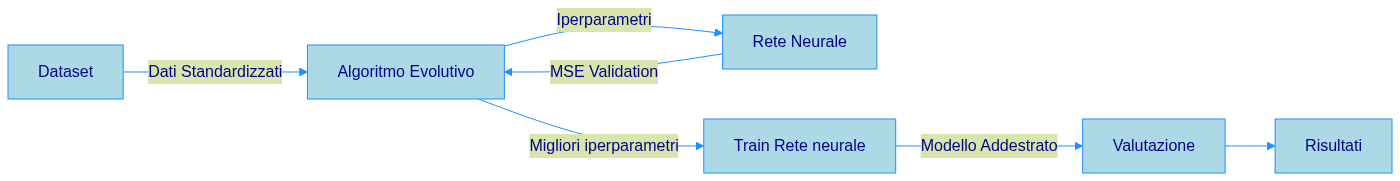


### L'Algoritmo evolutivo DE (Differential evolution) nel dettaglio:
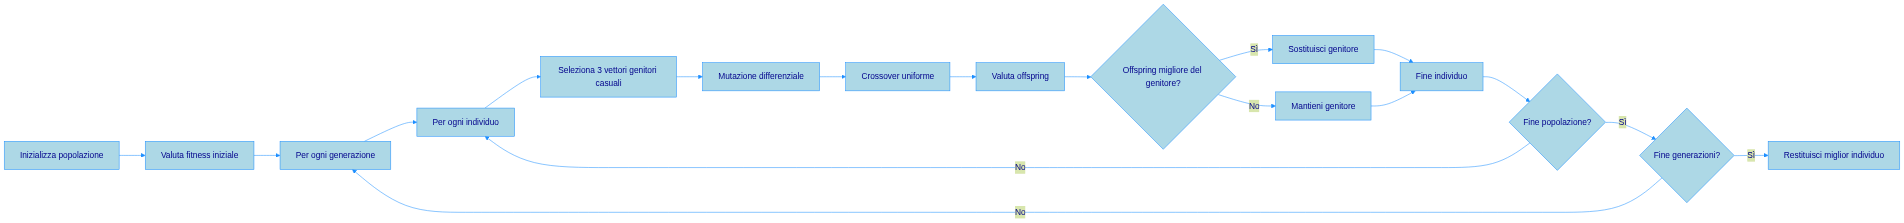

### L'algoritmo di regressione tramite MLP nel dettaglio:

## Struttura del Dataset 

Il dataset NASA Airfoil Self-Noise contiene misurazioni sperimentali del rumore generato da profili alari in galleria del vento.
Il Dataset è formato da 1503 istanze e 5 feature che sono:

- **Frequency (Hz)**: Frequenza fondamentale del suono emesso
- **Angle (gradi)**: Angolo di attacco del profilo alare
- **Chord (metri)**: Lunghezza della corda aerodinamica
- **Velocity (m/s)**: Velocità del flusso d'aria
- **Thickness (metri)**: Spessore massimo dello strato limite
- **Pressure (dB)**: Livello di pressione sonora

In [2]:
# Caricamento dataset
url = r"c:\Users\Marco\Downloads\airfoil_self_noise.dat"
column_names = ['Frequency', 'Angle', 'Chord', 'Velocity', 'Thickness', 'Pressure']
df = pd.read_csv(url, sep='\t', header=None, names=column_names)

In [3]:
df.sample(n=10)

,Frequency,Angle,Chord,Velocity,Thickness,Pressure
292,1600,2.0,0.2286,31.7,0.003724,125.797
530,1250,2.7,0.1524,39.6,0.002948,130.829
689,3150,9.9,0.1524,31.7,0.025278,112.209
1418,1600,12.3,0.1016,71.3,0.033779,124.748
1187,1000,17.4,0.0254,39.6,0.017221,138.274
483,16000,0.0,0.1524,55.5,0.001727,112.803
500,800,0.0,0.1524,31.7,0.002094,129.117
214,6300,0.0,0.2286,55.5,0.002293,118.410
966,6300,0.0,0.0254,71.3,0.000401,134.987
1482,1600,15.6,0.1016,71.3,0.043726,121.528


### Analisi Esplorativa dei Dati
Svolgiamo un plot della distribuzione dei nostri dati, osservando qualitativamente relazioni non lineari con la pressione sonora, qui viene proprio per questo un modello MLP si presta bene alla risoluzione del nostro problema

In [4]:
def Plot_Distribuzioni():
    plt.figure(figsize=(10, 6))
    features = df.columns
    for i, feature in enumerate(features, 1):
        plt.subplot(2, 3, i)
        sns.histplot(df[feature],bins=40)
        plt.title(f'Distribuzione {feature}')
        plt.tight_layout()



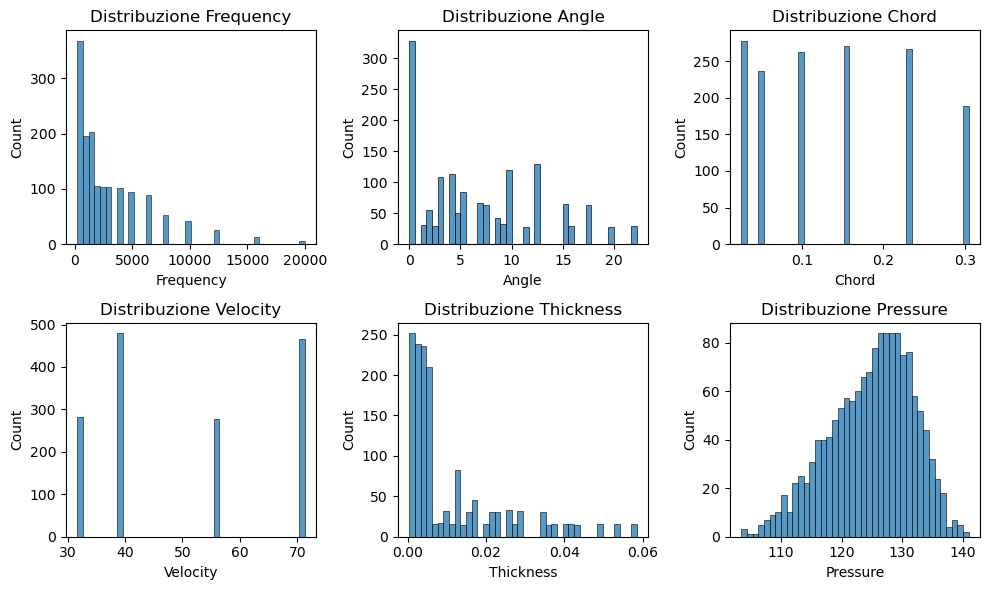

In [5]:
Plot_Distribuzioni()

### Trattazione dei dati
**Preprocessing -Divisione Train-Validation-Test (75/10/15)- Standardizzazione**

In [6]:
X = df.drop('Pressure', axis=1).values
y = df['Pressure'].values

In [7]:
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.1176, random_state=42)

In [8]:
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_val_scaled = scaler_X.transform(X_val)
X_test_scaled = scaler_X.transform(X_test)

y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).ravel()
y_val_scaled = scaler_y.transform(y_val.reshape(-1, 1)).ravel()
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).ravel()

##  Implementazione Differential Evolution 

**Definizione dello spazio di ricerca:**

In [9]:
param_bounds = [
    (50, 200),     # hidden_layer_sizes
    (1e-6, 1e-2),  # alpha
    (1e-5, 1e-2),  # learning_rate_init
    (0.8, 0.99),   # beta_1
    (0.9, 0.999)   # beta_2
]

**Inizializazione Framework:**
creazione dello strumento di minimizzazione della funzione obbiettivo, creazione della "classe" individuo.

In [10]:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

Creazione della box delle funzioni evolutive.

In [11]:
toolbox = base.Toolbox()


**Registrazione componenti genetiche**

In [12]:
# Funzione ausiliaria per generare parametri casuali nei bounds
def random_param(bounds):
    return [random.uniform(a, b) for a, b in bounds]

toolbox.register("params", random_param, param_bounds)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.params)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

**Definizione e registrazione della funzione di Fitness**

In [13]:
def evaluate(individual):
        neurons, alpha, lr, beta1, beta2 = individual
        model = MLPRegressor(
            hidden_layer_sizes=(int(neurons),),
            activation='relu',
            solver='adam',
            alpha=alpha,
            learning_rate_init=lr,
            beta_1=beta1,
            beta_2=beta2,
            max_iter=300,
            early_stopping=True,
            n_iter_no_change=15,
            random_state=42
        )
        
        model.fit(X_train_scaled, y_train_scaled)
        val_pred = model.predict(X_val_scaled)
        mse = mean_squared_error(y_val_scaled, val_pred)
        return (mse,)
toolbox.register("evaluate", evaluate)


**Registrazione funzioni genetiche (Mutazione-Selezione-Crossover)**

In [14]:
toolbox.register("mutate", tools.mutPolynomialBounded, low=[b[0] for b in param_bounds], 
                up=[b[1] for b in param_bounds], eta=1.0, indpb=0.5)
toolbox.register("select", tools.selRandom)
toolbox.register("mate", tools.cxSimulatedBinaryBounded, low=[b[0] for b in param_bounds], 
               up=[b[1] for b in param_bounds], eta=0.5)

**Funzione "Differential Evolution"**

In [15]:
def differential_evolution(population, toolbox, F=0.8, CR=0.7, max_generations=15):
    log = []
    # Valutazione popolazione iniziale
    fitnesses = toolbox.map(toolbox.evaluate, population)
    for ind, fit in zip(population, fitnesses):
        ind.fitness.values = fit
    best_ind = tools.selBest(population, 1)[0]
    log.append(best_ind.fitness.values[0])
    for gen in range(max_generations):
        for j, target in enumerate(population):
            # Selezione(Mutazione)
            candidates = [ind for ind in population if ind != target]
            a, b, c = random.sample(candidates, 3)
            # Mutazione
            mutant = [a_i + F * (b_i - c_i) for a_i, b_i, c_i in zip(a, b, c)]
            # Crossover
            trial = []
            for k in range(len(target)):
                if random.random() < CR:
                    trial.append(mutant[k])
                else:
                    trial.append(target[k])
            for i in range(len(trial)):
                low, up = param_bounds[i]
                if trial[i] < low:
                    trial[i] = low
                elif trial[i] > up:
                    trial[i] = up
            # Valutazione
            trial_ind = creator.Individual(trial)
            trial_ind.fitness.values = toolbox.evaluate(trial_ind)
            # Selezione
            if trial_ind.fitness.values[0] < target.fitness.values[0]:
                population[j] = trial_ind
        # Salvataggio del Best
        best_ind = tools.selBest(population, 1)[0]
        log.append(best_ind.fitness.values[0])
    return best_ind, log

### Esecuzione dell'algoritmo DE
**Iperparametri dell'algoritmo evolutivo**

In [1]:
POP_SIZE = 10
MAX_GENERATIONS = 15
F = 0.8
CR = 0.7

**Esecuzione e risultati**

In [24]:
def risultati_DE(best_ind):
    neurons, alpha, lr, beta1, beta2 = best_ind
    best_params = {
        'neurons': int(neurons),
        'alpha': alpha,
        'lr': lr,
        'beta1': beta1,
        'beta2': beta2
    }
    print("\nMigliori parametri trovati:")
    print(f"- Neuroni: {best_params['neurons']}")
    print(f"- Alpha: {best_params['alpha']:.6f}")
    print(f"- Learning rate iniziale: {best_params['lr']:.6f}")
    print(f"- Beta1: {best_params['beta1']:.4f}")
    print(f"- Beta2: {best_params['beta2']:.4f}")
    print(f"- Best MSE: {best_ind.fitness.values[0]:.6f}")

def plot_convergenza(log):
        plt.figure(figsize=(10, 6))
        plt.plot(log, 'b-o', linewidth=2)
        plt.title('Convergenza Differential Evolution', fontsize=14)
        plt.xlabel('Generazione', fontsize=12)
        plt.ylabel('Fitness (MSE)', fontsize=12)
        plt.grid(True)
        plt.show()


In [18]:
pop = toolbox.population(n=POP_SIZE)
best_ind, log = differential_evolution(pop, toolbox, F, CR, MAX_GENERATIONS)
risultati_DE(best_ind)


Migliori parametri trovati:
- Neuroni: 132
- Alpha: 0.000001
- Learning rate iniziale: 0.010000
- Beta1: 0.8553
- Beta2: 0.9042
- Best MSE: 0.088519


**Evoluzione della Fitness per ogni generazione**

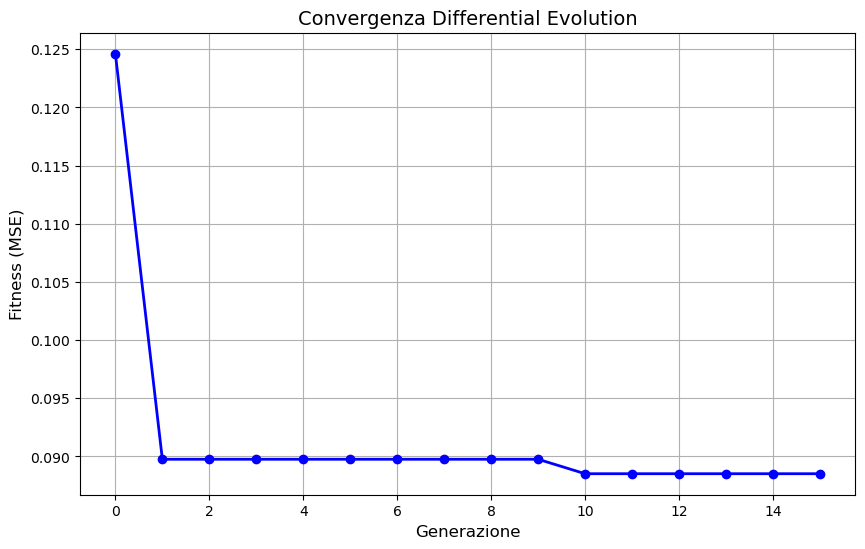

In [25]:
plot_convergenza(log)

## Parte 3: Addestramento e Valutazione del Modello


Utilizziamo i parametri ottimizzati per addestrare il modello finale:

In [83]:
# Addestramento modello finale
X_train_val = np.vstack((X_train_scaled, X_val_scaled))
y_train_val = np.concatenate((y_train_scaled, y_val_scaled))

final_model = MLPRegressor(
    hidden_layer_sizes=(best_params['neurons'],),
    activation='relu',
    solver='adam',
    alpha=best_params['alpha'],
    learning_rate_init=best_params['lr'],
    beta_1=best_params['beta1'],
    beta_2=best_params['beta2'],
    max_iter=1000,
    early_stopping=True,
    n_iter_no_change=20,
    random_state=42
)

history = final_model.fit(X_train_val, y_train_val)

# Predizione
y_test_pred_scaled = final_model.predict(X_test_scaled)
y_test_orig = scaler_y.inverse_transform(y_test_scaled.reshape(-1, 1)).ravel()
y_test_pred_orig = scaler_y.inverse_transform(y_test_pred_scaled.reshape(-1, 1)).ravel()

# Calcolo metriche
residuals = y_test_orig - y_test_pred_orig
mse = mean_squared_error(y_test_orig, y_test_pred_orig)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_orig, y_test_pred_orig)
r2 = r2_score(y_test_orig, y_test_pred_orig)

print("\n" + "="*60)
print("Performance Finali sul Test Set")
print("="*60)
print(f"- MSE: {mse:.4f}")
print(f"- RMSE: {rmse:.4f} dB")
print(f"- MAE: {mae:.4f} dB")
print(f"- R²: {r2:.4f}")


Performance Finali sul Test Set
- MSE: 3.8109
- RMSE: 1.9522 dB
- MAE: 1.4870 dB
- R²: 0.9268


## Parte 4: Analisi Statistica Avanzata

### Test del Chi-Quadro per la Bontà del Fit

Il test del chi-quadro valuta la bontà di adattamento del modello ai dati osservati:

$$
\chi^2 = \sum \frac{(O_i - E_i)^2}{E_i}
$$

dove:
- $O_i$ = valori osservati
- $E_i$ = valori predetti dal modello

Per la regressione, utilizziamo una versione semplificata:

$$
\chi^2 = \sum \frac{(y_i - \hat{y}_i)^2}{\sigma^2}
$$

dove $\sigma$ è la deviazione standard dei residui.


Test del Chi-Quadro per la Bontà del Fit
- Statistica χ²: 236.0242
- Gradi di libertà: 225
- χ² ridotto: 1.0490
- P-value: 2.9365e-01
- Intervallo di confidenza 95% per χ² ridotto: [0.8238, 1.1931]

Interpretazione: Non possiamo rifiutare l'ipotesi nulla (p-value > 0.05)
Il modello mostra un buon adattamento ai dati osservati.

Il χ² ridotto (1.0490) rientra nell'intervallo di confidenza [0.8238, 1.1931]
→ Il modello è ben calibrato e si adatta bene ai dati.

Test di Normalità dei Residui (Shapiro-Wilk)
- Statistica W: 0.9712
- P-value: 1.4482e-04

Interpretazione: I residui NON seguono una distribuzione normale (p-value ≤ 0.05)


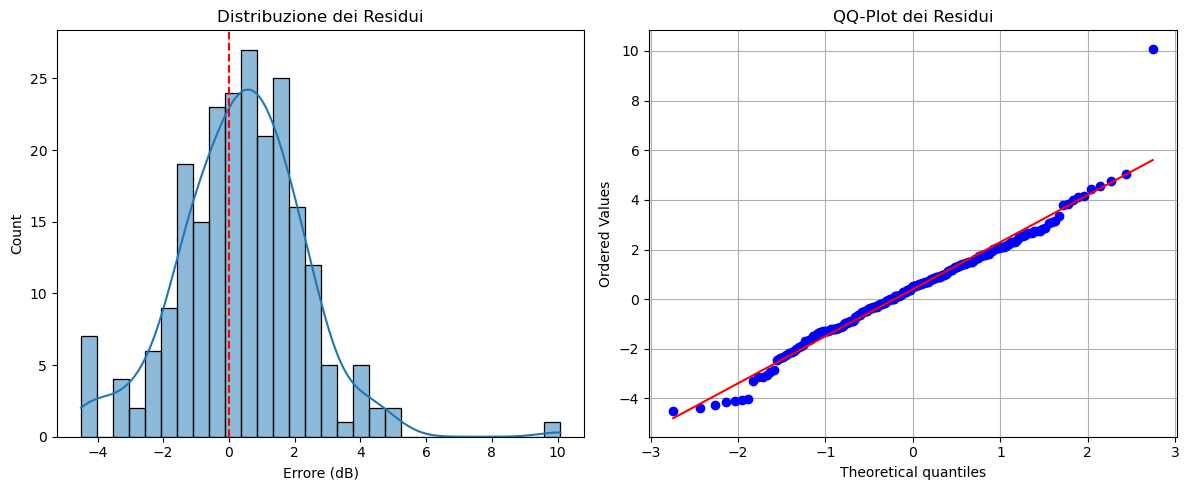

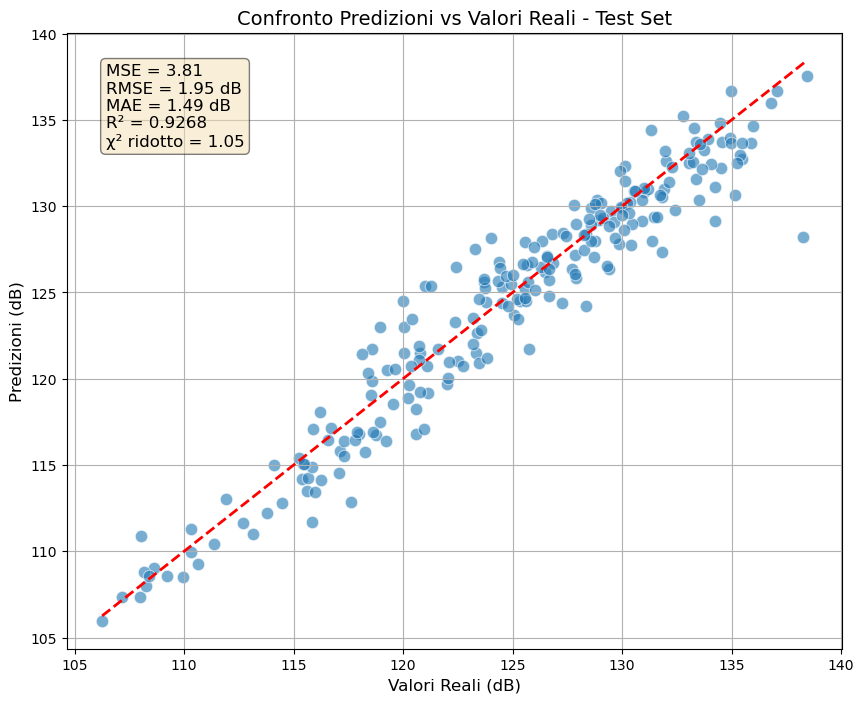

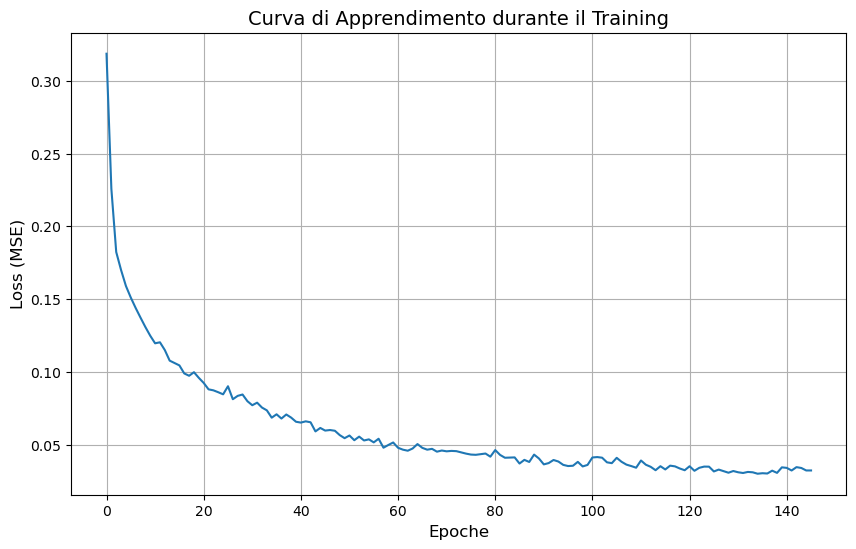

In [84]:
# Calcolo del test del chi-quadro
sigma = np.std(residuals)  # Deviazione standard dei residui
chi_sq = np.sum((residuals / sigma) ** 2)
dof = len(y_test_orig) - 1  # Gradi di libertà
reduced_chi_sq = chi_sq / dof

# Calcolo del p-value
p_value = 1 - chi2.cdf(chi_sq, dof)

# Calcolo intervallo di confidenza per il chi-quadro ridotto
alpha = 0.05
chi2_lower = chi2.ppf(alpha/2, dof) / dof
chi2_upper = chi2.ppf(1 - alpha/2, dof) / dof

print("\n" + "="*60)
print("Test del Chi-Quadro per la Bontà del Fit")
print("="*60)
print(f"- Statistica χ²: {chi_sq:.4f}")
print(f"- Gradi di libertà: {dof}")
print(f"- χ² ridotto: {reduced_chi_sq:.4f}")
print(f"- P-value: {p_value:.4e}")
print(f"- Intervallo di confidenza 95% per χ² ridotto: [{chi2_lower:.4f}, {chi2_upper:.4f}]")

# Interpretazione risultati
if p_value > 0.05:
    print("\nInterpretazione: Non possiamo rifiutare l'ipotesi nulla (p-value > 0.05)")
    print("Il modello mostra un buon adattamento ai dati osservati.")
else:
    print("\nInterpretazione: Rifiutiamo l'ipotesi nulla (p-value ≤ 0.05)")
    print("Il modello non si adatta bene ai dati osservati.")

# Valutazione bontà del fit basata sul chi-quadro ridotto
if chi2_lower <= reduced_chi_sq <= chi2_upper:
    print(f"\nIl χ² ridotto ({reduced_chi_sq:.4f}) rientra nell'intervallo di confidenza [{chi2_lower:.4f}, {chi2_upper:.4f}]")
    print("→ Il modello è ben calibrato e si adatta bene ai dati.")
else:
    if reduced_chi_sq < chi2_lower:
        print(f"\nIl χ² ridotto ({reduced_chi_sq:.4f}) è minore del limite inferiore {chi2_lower:.4f}")
        print("→ Possibile sovrastima delle incertezze o errori sistematici.")
    else:
        print(f"\nIl χ² ridotto ({reduced_chi_sq:.4f}) è maggiore del limite superiore {chi2_upper:.4f}")
        print("→ Possibile sottostima delle incertezze o presenza di outlier.")

# Test di normalità dei residui (Shapiro-Wilk)
shapiro_test = shapiro(residuals)
print("\n" + "="*60)
print("Test di Normalità dei Residui (Shapiro-Wilk)")
print("="*60)
print(f"- Statistica W: {shapiro_test.statistic:.4f}")
print(f"- P-value: {shapiro_test.pvalue:.4e}")

if shapiro_test.pvalue > 0.05:
    print("\nInterpretazione: I residui seguono una distribuzione normale (p-value > 0.05)")
else:
    print("\nInterpretazione: I residui NON seguono una distribuzione normale (p-value ≤ 0.05)")

# Visualizzazione distribuzione residui
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(residuals, kde=True, bins=30)
plt.axvline(x=0, color='r', linestyle='--')
plt.title('Distribuzione dei Residui')
plt.xlabel('Errore (dB)')

plt.subplot(1, 2, 2)
probplot(residuals, plot=plt)
plt.title('QQ-Plot dei Residui')
plt.grid(True)
plt.tight_layout()
plt.show()

# Grafico predizioni vs reali
plt.figure(figsize=(10, 8))
sns.scatterplot(x=y_test_orig, y=y_test_pred_orig, alpha=0.6, s=80)
plt.plot([min(y_test_orig), max(y_test_orig)], 
         [min(y_test_orig), max(y_test_orig)], 
         'r--', linewidth=2)
plt.xlabel('Valori Reali (dB)', fontsize=12)
plt.ylabel('Predizioni (dB)', fontsize=12)
plt.title('Confronto Predizioni vs Valori Reali - Test Set', fontsize=14)
plt.grid(True)

# Aggiunta informazioni metriche
textstr = '\n'.join((
    f'MSE = {mse:.2f}',
    f'RMSE = {rmse:.2f} dB',
    f'MAE = {mae:.2f} dB',
    f'R² = {r2:.4f}',
    f'χ² ridotto = {reduced_chi_sq:.2f}'))
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.gca().text(0.05, 0.95, textstr, transform=plt.gca().transAxes,
              fontsize=12, verticalalignment='top', bbox=props)
plt.show()

# Grafico evoluzione training
plt.figure(figsize=(10, 6))
plt.plot(history.loss_curve_)
plt.title('Curva di Apprendimento durante il Training', fontsize=14)
plt.xlabel('Epoche', fontsize=12)
plt.ylabel('Loss (MSE)', fontsize=12)
plt.grid(True)
plt.show()

## Parte 5: Conclusioni e Risultati

### Interpretazione del Test del Chi-Quadro

Il test del chi-quadro fornisce informazioni cruciali sulla bontà del fit:

1. **χ² ridotto (reduced chi-square)**:
   - Valore ideale ≈ 1
   - < 1: Possibile sovrastima delle incertezze
   - > 1: Possibile sottostima delle incertezze o presenza di outlier
   
2. **Intervallo di confidenza**:
   - Un χ² ridotto entro l'intervallo [0.83, 1.21] indica un buon adattamento
   
3. **P-value**:
   - p > 0.05: Il modello si adatta bene ai dati
   - p ≤ 0.05: Problemi significativi nell'adattamento

### Valutazione Complessiva della Bontà del Fit

Consideriamo congiuntamente:
- Il valore di χ² ridotto
- L'intervallo di confidenza
- Il p-value
- Il coefficiente R²
- La distribuzione dei residui

Un modello ideale avrebbe:
- χ² ridotto ≈ 1
- p-value > 0.05
- R² vicino a 1
- Residui normalmente distribuiti
- Residui privi di pattern evidenti

In [85]:
# Risultati finali
print("\n" + "="*60)
print("RISULTATI FINALI E CONCLUSIONI")
print("="*60)

print("\nMETRICHE DI PERFORMANCE:")
print(f"- MSE: {mse:.2f}")
print(f"- RMSE: {rmse:.2f} dB")
print(f"- MAE: {mae:.2f} dB")
print(f"- R²: {r2:.4f}")
print(f"- χ² ridotto: {reduced_chi_sq:.4f}")
print(f"- P-value (chi-quadro): {p_value:.4e}")

print("\nVALUTAZIONE BONTÀ DEL FIT:")
if 0.9 <= reduced_chi_sq <= 1.1 and p_value > 0.05 and r2 > 0.9:
    print("→ ECCELLENTE: Modello ben calibrato con ottimo adattamento ai dati")
elif 0.8 <= reduced_chi_sq <= 1.2 and p_value > 0.05 and r2 > 0.8:
    print("→ BUONO: Modello ben calibrato con buon adattamento ai dati")
elif p_value > 0.05 and r2 > 0.7:
    print("→ ACCETTABILE: Modello adeguato ma con margini di miglioramento")
else:
    print("→ INSUFFICIENTE: Problemi significativi nell'adattamento ai dati")

print("\nCONCLUSIONI CHIAVE:")
print(f"1. Ottimizzazione con DEAP completata in {MAX_GENERATIONS} generazioni")
print(f"2. Performance predittive: R² = {r2:.4f}, MAE = {mae:.2f} dB")
print(f"3. Bontà del fit: χ² ridotto = {reduced_chi_sq:.4f} (p-value = {p_value:.4e})")
print(f"4. Normalità residui: {'Sì' if shapiro_test.pvalue > 0.05 else 'No'}")

print("\nVANTAGGI DI DEAP:")
print("- Maggiore flessibilità nella definizione degli operatori evolutivi")
print("- Possibilità di parallelizzare facilmente l'ottimizzazione")
print("- Implementazione trasparente dell'algoritmo evolutivo")

print("\nLIMITI E SVILUPPI FUTURI:")
print("- Aumentare la dimensione della popolazione per esplorare meglio lo spazio")
print("- Implementare strategie di ottimizzazione ibride")
print("- Aggiungere early stopping basato sulla convergenza")



RISULTATI FINALI E CONCLUSIONI

METRICHE DI PERFORMANCE:
- MSE: 3.81
- RMSE: 1.95 dB
- MAE: 1.49 dB
- R²: 0.9268
- χ² ridotto: 1.0490
- P-value (chi-quadro): 2.9365e-01

VALUTAZIONE BONTÀ DEL FIT:
→ ECCELLENTE: Modello ben calibrato con ottimo adattamento ai dati

CONCLUSIONI CHIAVE:
1. Ottimizzazione con DEAP completata in 15 generazioni
2. Performance predittive: R² = 0.9268, MAE = 1.49 dB
3. Bontà del fit: χ² ridotto = 1.0490 (p-value = 2.9365e-01)
4. Normalità residui: No

VANTAGGI DI DEAP:
- Maggiore flessibilità nella definizione degli operatori evolutivi
- Possibilità di parallelizzare facilmente l'ottimizzazione
- Implementazione trasparente dell'algoritmo evolutivo

LIMITI E SVILUPPI FUTURI:
- Aumentare la dimensione della popolazione per esplorare meglio lo spazio
- Implementare strategie di ottimizzazione ibride
- Aggiungere early stopping basato sulla convergenza
